In [1]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

In [2]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        if not os.path.isfile(filepath):
            utils.download_url(URL + filename, dataset_location, filename, None)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [3]:
train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", 64)

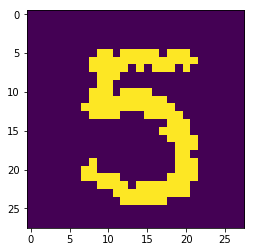

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train_loader:
    plt.imshow(x[0, 0])
    break

In [52]:
import vae  # needed to allow the reload
import importlib
importlib.reload(vae)  # forces a reloading of the module (because jupyter notebook will not reload it after it has been modified)
from vae import VAE
from torch import optim

device = torch.device("cuda")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


def loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train_vae(epoch, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

    
def test_vae(epoch, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [53]:
for epoch in range(20):
    train_vae(epoch, train_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 563.821533
Train Epoch: 0 [6400/50000 (13%)]	Loss: 218.233353
Train Epoch: 0 [12800/50000 (26%)]	Loss: 189.457657
Train Epoch: 0 [19200/50000 (38%)]	Loss: 167.045456
Train Epoch: 0 [25600/50000 (51%)]	Loss: 161.924500
Train Epoch: 0 [32000/50000 (64%)]	Loss: 155.691879
Train Epoch: 0 [38400/50000 (77%)]	Loss: 156.223328
Train Epoch: 0 [44800/50000 (90%)]	Loss: 146.818283
====> Epoch: 0 Average loss: 183.8234
Train Epoch: 1 [0/50000 (0%)]	Loss: 137.664185
Train Epoch: 1 [6400/50000 (13%)]	Loss: 141.826996
Train Epoch: 1 [12800/50000 (26%)]	Loss: 132.653320
Train Epoch: 1 [19200/50000 (38%)]	Loss: 121.459938
Train Epoch: 1 [25600/50000 (51%)]	Loss: 125.207146
Train Epoch: 1 [32000/50000 (64%)]	Loss: 121.468819
Train Epoch: 1 [38400/50000 (77%)]	Loss: 126.338188
Train Epoch: 1 [44800/50000 (90%)]	Loss: 114.920319
====> Epoch: 1 Average loss: 126.0084
Train Epoch: 2 [0/50000 (0%)]	Loss: 113.005142
Train Epoch: 2 [6400/50000 (13%)]	Loss: 117.441986
Train 

Train Epoch: 18 [19200/50000 (38%)]	Loss: 97.718872
Train Epoch: 18 [25600/50000 (51%)]	Loss: 95.081802
Train Epoch: 18 [32000/50000 (64%)]	Loss: 93.556259
Train Epoch: 18 [38400/50000 (77%)]	Loss: 92.734146
Train Epoch: 18 [44800/50000 (90%)]	Loss: 93.239227
====> Epoch: 18 Average loss: 94.0313
Train Epoch: 19 [0/50000 (0%)]	Loss: 93.091507
Train Epoch: 19 [6400/50000 (13%)]	Loss: 90.007622
Train Epoch: 19 [12800/50000 (26%)]	Loss: 96.397949
Train Epoch: 19 [19200/50000 (38%)]	Loss: 93.749725
Train Epoch: 19 [25600/50000 (51%)]	Loss: 92.763412
Train Epoch: 19 [32000/50000 (64%)]	Loss: 92.896576
Train Epoch: 19 [38400/50000 (77%)]	Loss: 93.889969
Train Epoch: 19 [44800/50000 (90%)]	Loss: 94.129547
====> Epoch: 19 Average loss: 93.7822
